In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - velocity_radial_profiles_dr16.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
# 
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Examine the radial trends in velocity using DR16 data.
'''

__author__ = "James Lane"

In [2]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt

## Astropy
from astropy import units as apu
from astropy.io import fits

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.util
import ast1501.fourier
import ast1501.linear_model

In [3]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Future work

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Keywords and File Names for Gaia

In [4]:
n_bs = 100

In [5]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dr16_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [6]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [7]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
gc_R = data_low_z['R']
gc_phi = data_low_z['PHI']
gc_z = data_low_z['Z']
gc_vR = data_low_z['VR']
gc_vT = data_low_z['VT']
gc_vz = data_low_z['VZ']

# Adjust the phi velocities 
gc_phi[ np.where( (gc_phi > np.pi) ) ] -= 2*np.pi

## Set the grid parameters

In [8]:
# Radial bin range and size
R_lim = [5,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lim[0], R_lim[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lim = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lim[0], phi_lim[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lim = [0, np.pi/2]
phib_bin_size = np.pi/60
phib_bin_cents = np.arange( phib_lim[0], phib_lim[1], phib_bin_size ) + phi_bin_size/2

In [9]:
lm = ast1501.linear_model.LinearModel(instantiate_method=1, gc_R=gc_R, 
    gc_phi=gc_phi, gc_vR=gc_vR, gc_vT=gc_vT, R_lims=R_lim, 
    R_bin_size=R_bin_size, phi_lims=phi_lim, 
    phi_bin_size=phi_bin_size, phib_lims=phib_lim,
    phib_bin_size=phib_bin_size)

## Tangential Velocity

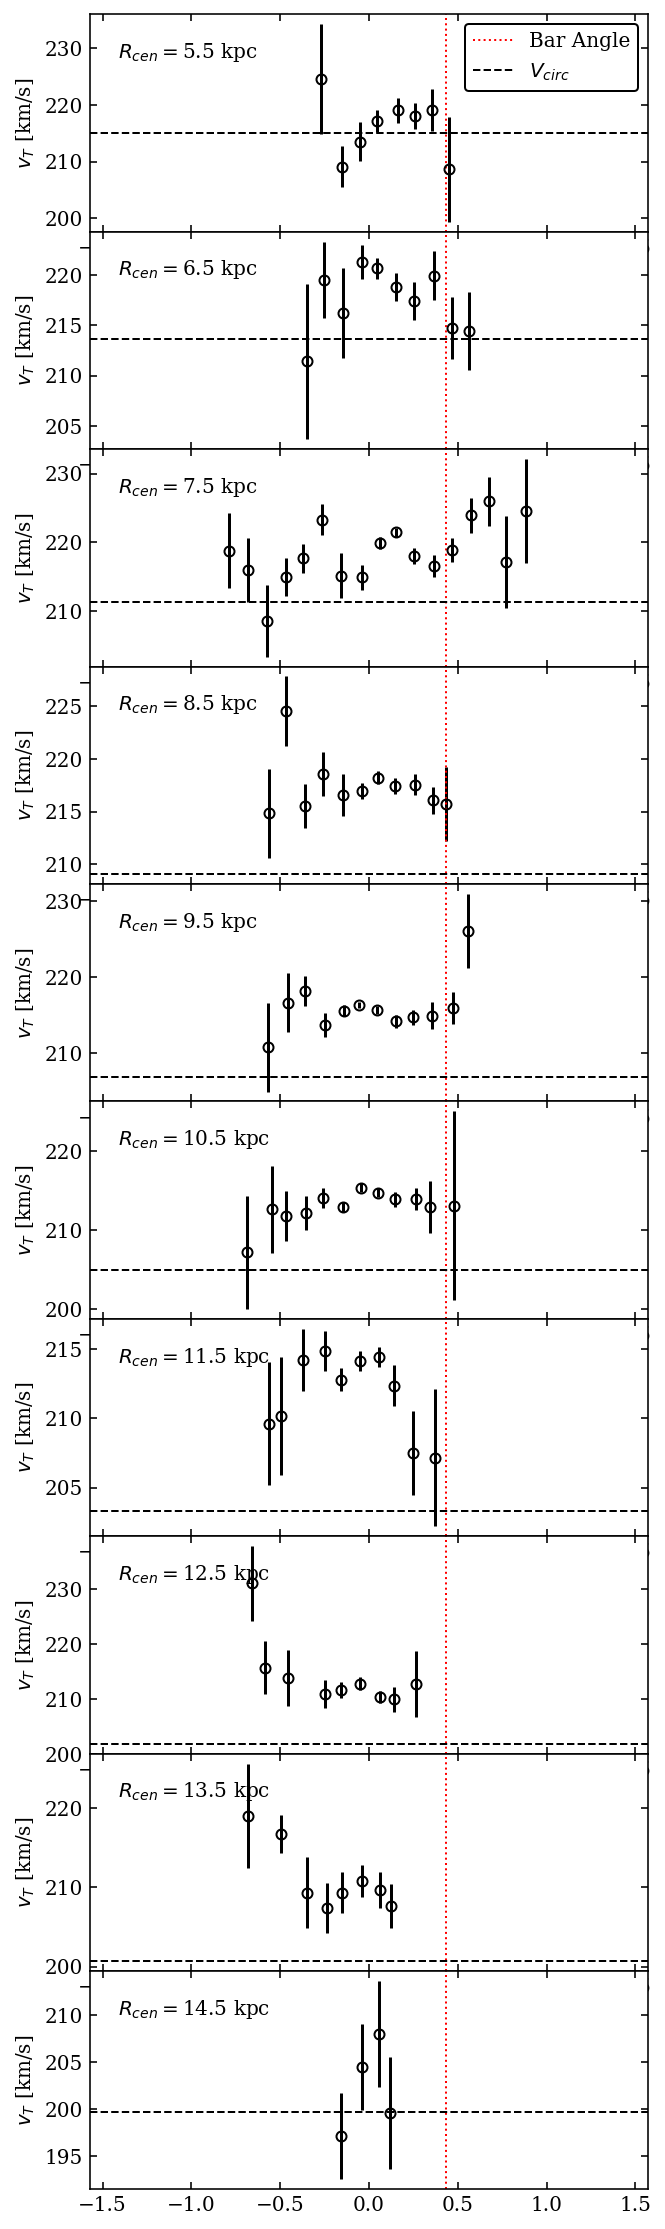

In [12]:
fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vT',plot_best_fit=False)
fig.set_facecolor('White')
plt.show()

# Radial Velocity

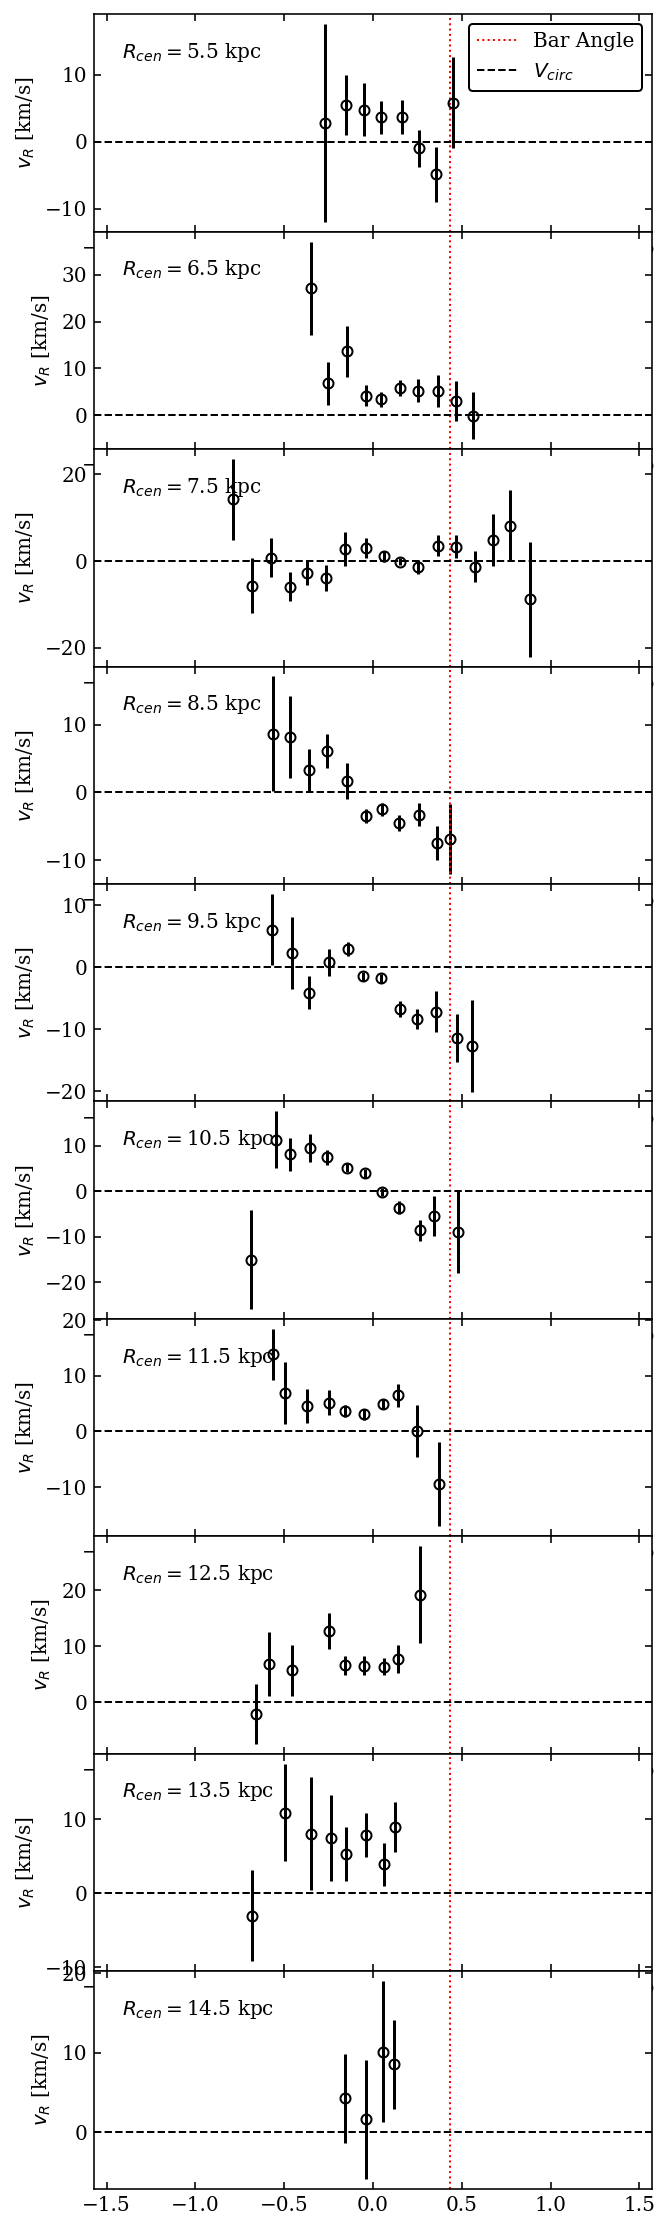

In [18]:
fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False)
fig.set_facecolor('White')
plt.show()

# Old Plotting Routines

In [ ]:
# def radial_velocity(R_bin_cents, R_bin_size, phi_range, phi_bin_size, gc_R, gc_phi, gc_v,
#                     phi_bin_size_in_arc=True
#                    ):
    
#     n_R = len(R_bin_cents)
    
#     # Declare the figure
#     fig = plt.figure( figsize=(15,n_R*3) )
#     axs = fig.subplots(nrows=n_R, ncols=3)
    
#     # Loop over all radii
#     for i in range( n_R ):
        
#         # Select the stars in this bin
#         stars_in_bin = np.where( (gc_R > (R_bin_cents[i]-R_bin_size/2) ) & 
#                                  (gc_R < (R_bin_cents[i]+R_bin_size/2) ) )[0]
#         gcR_in_bin = gc_R[stars_in_bin]
#         gcv_in_bin = gc_v[stars_in_bin]
#         gcphi_in_bin = gc_phi[stars_in_bin]

#         if phi_bin_size_in_arc:
#             # Bin the Gaia data in arc
#             arc_min = phi_range[0]*R_bin_cents[i]
#             arc_max = phi_range[1]*R_bin_cents[i]
#             phi_bin_cents = np.arange( arc_min, arc_max, phi_bin_size)
#             phi_bin_cents += ( ( arc_max - arc_min ) % phi_bin_size )/2
#             phi_bin_cents /= R_bin_cents[i]
#         else:
#             phi_bin_cents = np.arange( phi_range[0], phi_range[1], phi_bin_size )
#             phi_bin_cents += ( ( phi_range[1] - phi_range[0] ) % phi_bin_size )/2
#         ##ie
        
#         # Make the bin edges and bin velocity, R, and number in phi
#         phi_bin_edges = np.append( phi_bin_cents-np.diff(phi_bin_cents)[0], 
#                                    phi_bin_cents[-1]+np.diff(phi_bin_cents)[0] )
#         binned_v, _, _ = binned_statistic(gcphi_in_bin, gcv_in_bin, bins=phi_bin_edges, statistic='mean')
#         binned_R, _, _ = binned_statistic(gcphi_in_bin, gcR_in_bin, bins=phi_bin_edges, statistic='mean')        
        
#         # Make a number histogram to examine whether there is enough stars for a valid measurement
#         binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_bin_edges)
#         binned_n = binned_n.astype('float')
#         min_N = 20
#         where_low_bin_numbers = np.where(binned_n < min_N)
#         binned_v[ where_low_bin_numbers ] = np.nan
#         binned_R[ where_low_bin_numbers ] = np.nan
#         binned_n[ where_low_bin_numbers ] = np.nan

#         # Find where there was data
#         where_data = np.where( np.isfinite(binned_v) )
#         where_no_data = np.where( np.isnan(binned_v) )
#         binned_v[ where_no_data ] = np.nan
#         binned_R[ where_no_data ] = np.nan
#         binned_n[ where_no_data ] = np.nan

#         # Subtract off mean where non-zero
#         binned_v -= np.nanmean( binned_v[where_data] )
        
#         axs[i,0].plot( phi_bin_cents, binned_v, linewidth=0.5, color='Black' )
#         axs[i,1].plot( phi_bin_cents, binned_R, linewidth=0.5, color='Black' )
#         axs[i,2].plot( phi_bin_cents, binned_n, linewidth=0.5, color='Black' )
#         axs[i,0].scatter( phi_bin_cents, binned_v, s=5, color='Black' )
#         axs[i,1].scatter( phi_bin_cents, binned_R, s=5, color='Black' )
#         axs[i,2].scatter( phi_bin_cents, binned_n, s=5, color='Black' )
        
#         axs[i,2].set_yscale("log", nonposy='clip')
        
#         axs[i,0].annotate( r'$R_{cen}=$'+str(R_bin_cents[i])+' kpc', xy=(0.05,0.8), xycoords='axes fraction' )
#         axs[i,1].set_ylim( R_bin_cents[i]-R_bin_size/2, R_bin_cents[i]+R_bin_size/2 )
        
#         axs[i,0].set_xlim( phi_range[0], phi_range[1] )
# #         axs[i,0].set_ylim( -30, 30 )
#         axs[i,1].set_xlim( phi_range[0], phi_range[1] )
#         axs[i,2].set_xlim( phi_range[0], phi_range[1] )
#         axs[i,2].set_ylim( 1, 5000)
        
#         # Add a bar
#         axs[i,0].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
#         axs[i,1].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
#         axs[i,2].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        
#         axs[i,0].axhline( 0.0, linestyle='dashed', linewidth=0.5 )
#         axs[i,1].axhline( R_bin_cents[i], linestyle='dashed', linewidth=0.5 )
#         axs[i,2].axhline( min_N, linestyle='dashed', linewidth=0.5 )
        
#         axs[i,1].set_ylabel(r'$\bar{R}$ [kpc]')
#         axs[i,2].set_ylabel(r'$N$')
        
#         axs[i,0].set_xlabel(r'$\phi$')
#         axs[i,1].set_xlabel(r'$\phi$')
#         axs[i,2].set_xlabel(r'$\phi$')
        
#     ###i

#     return fig, axs

# #def
    

In [ ]:
# R_bin_size = 1.0
# R_range = [5,15]
# R_bin_cents = np.arange(R_range[0], R_range[1], R_bin_size) + R_bin_size/2

# arc_bin_size = 1.0
# phi_range = [-np.pi/2,np.pi/2]

In [27]:
# fig, axs = radial_velocity( R_bin_cents, R_bin_size, phi_range, arc_bin_size, gc_R, gc_phi, gc_vT,
#                             phi_bin_size_in_arc=True)

# for i in range( len(R_bin_cents) ):
#     axs[i,0].set_ylabel(r'$v_{T}- \langle v_{T} \rangle$ [km/s]')
# ##ax

# fig.subplots_adjust( wspace=0.2, hspace=0.3 )
# fig.set_facecolor('White')

# plt.show()

In [28]:
# fig, axs = radial_velocity( R_bin_cents, R_bin_size, phi_range, arc_bin_size, gc_R, gc_phi, gc_vR,
#                             phi_bin_size_in_arc=True)

# for i in range( len(R_bin_cents) ):
#     axs[i,0].set_ylabel(r'$v_{R}-\langle v_{R} \rangle$ [km/s]')
# ##ax

# fig.subplots_adjust( wspace=0.2, hspace=0.3 )

# plt.show()